In [315]:
import numpy as np

#visuals
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

#Interactive
from ipywidgets.widgets import * 
import ipywidgets as widgets

#is vectorization useful here?
import time

#Hugo code
import Utility
import PythonKEX 
import normfileKEX

In [316]:
# plan
# get sinogram
# array multiply sinogram with normalization components
# make histo image from sinogram 

 return list mode paths, sinograms paths, phantom title (Cannula or Cylinder ), and paths to reconstructions 
histogram dimensions:
 ['TOF bin ', 'michelogram bin ', 'transaxial angle bin ', 'radial offset bin ']
histogram bins per dimension:
 (14, 621, 168, 400)


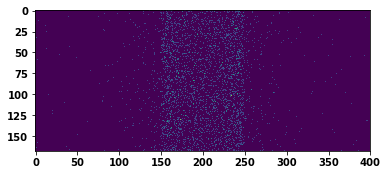

In [317]:
#first use the full sinogram
print(PythonKEX.define_KEX_dataset.__doc__)
LM_paths, sino_paths, phantom_str, recon_paths = PythonKEX.define_KEX_dataset(isKanyl=False)

#later, sinograms from LM timeslice can be implemented
gate_number = 0
#unsigned 16 bit bins in histogram
data_type =np.ushort
with open(sino_paths[gate_number], 'rb') as file:
    sinogram_1D = np.fromfile(file,dtype=data_type)
sinogram_4D = np.reshape(sinogram_1D, newshape=Utility.HISTOGRAM_SHAPE)

print("histogram dimensions:\n", Utility.HISTOGRAM_DIMENSION_TITLES)
print("histogram bins per dimension:\n", Utility.HISTOGRAM_SHAPE)
plt.imshow(sinogram_4D[0,50])
plt.show()

norm. file components:
 ['geometric effects', 'crystal interference', 'crystal efficiencies', 'axial effects', 'paralyzing ring DT parameters', 'non-paralyzing ring DT parameters', 'TX crystal DT parameter']
number of matrix dimensions:
 [2, 2, 2, 1, 1, 1, 1]
sizes:
 [(400, 109), (14, 400), (672, 55), 621, 55, 55, 14]
axes labels:
 [('sinogram projection bins', 'sinogram planes'), ('crystal number', 'sinogram projection bins'), ('crystal number', 'ring number'), 'plane number', 'ring number', 'ring number', 'crystal number']
last matrix:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


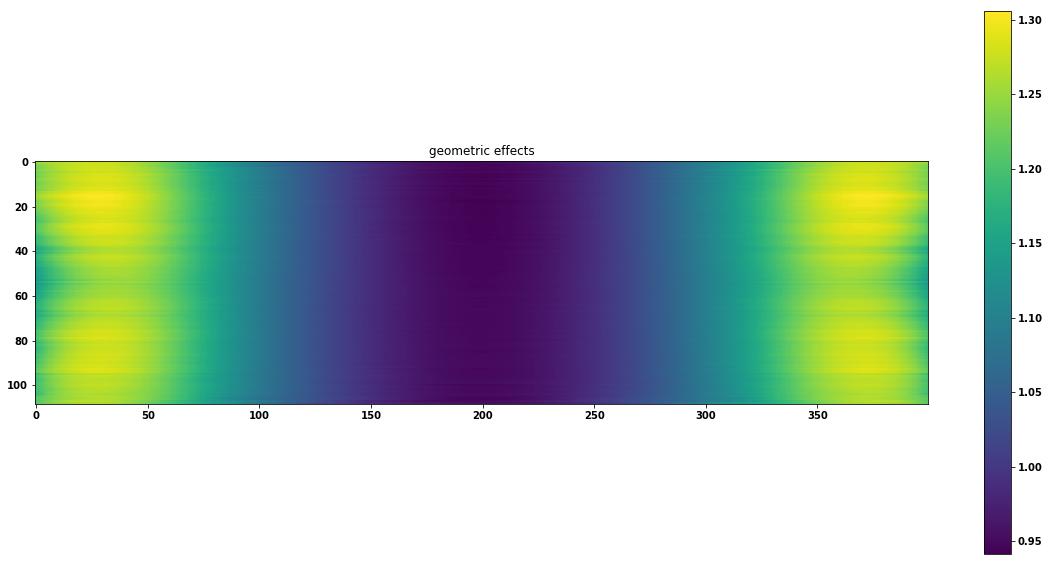

In [318]:
#normalization components
#inspect loading of norm file
print("norm. file components:\n",normfileKEX.normalization_component)
print("number of matrix dimensions:\n", normfileKEX.number_of_dimensions)
print("sizes:\n", normfileKEX.matrix_size)
print("axes labels:\n", normfileKEX.matrix_axis_labels)
print("last matrix:\n", normfileKEX.matrices[-1])
c = 0
plt.figure(figsize=[20,10])
plt.imshow(np.swapaxes(normfileKEX.matrices[c],0,1))
plt.title(normfileKEX.normalization_component[c])
plt.colorbar()
plt.show()

In [329]:
# ignore the dead time components in normalization
# these seem unreliable, and singles rates are unavailable (possibly be stored in LM data)
print(Utility.HISTOGRAM_DIMENSION_TITLES)
print(Utility.HISTOGRAM_SHAPE)
ranges = []
for upper in Utility.HISTOGRAM_SHAPE:
    ranges.append(np.arange(upper))

#meshgrid is simple conceptually, but too memory expensive
#TOF, MI, TX, RO = np.meshgrid(ranges[0], ranges[1], ranges[2], ranges[3])

# Histogram shape [tof,mi,tx,ro] should line up with [ro,mi[segment 0]] of geometric effects and 
# by summing the efficiencies of the crystals for each detector side of a given LOR bin ...
# this is essentially a product of convolutions, although this might be difficult to implement
# also consider the cyclic nature of geometric effect
kernel = np.ones([Utility.TRANSAXIAL_COMPRESSION, Utility.AXIAL_COMPRESSION])
geometry_norm = normfileKEX.matrices[0]
#print("geometry_norm shape", geometry_norm.shape)
geometry_norm = np.swapaxes(geometry_norm,0,1)
newshape = (1,sinogram_4D.shape[1],1,sinogram_4D.shape[-1])

#expand to oblique sinograms by axial index
geometry_norm = np.reshape(geometry_norm[Utility.AXIAL_OF_MI], newshape)
geometry_normalized_sinogram = sinogram_4D / geometry_norm

['TOF bin ', 'michelogram bin ', 'transaxial angle bin ', 'radial offset bin ']
(14, 621, 168, 400)


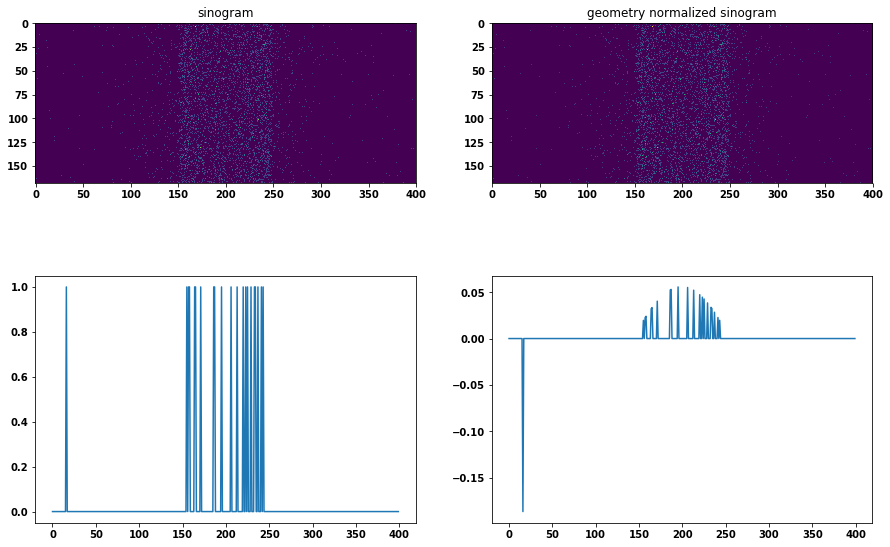

In [330]:
#plot geometry normalized sinogram
tof = 0
mi = 50
tx = 100
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(sinogram_4D[tof,mi])
plt.title("sinogram")
plt.subplot(2,2,2)
plt.imshow(geometry_normalized_sinogram[tof,mi])
plt.title("geometry normalized sinogram")
plt.subplot(2,2,3)
plt.plot(sinogram_4D[tof,mi,tx])
plt.subplot(2,2,4)
plt.plot(geometry_normalized_sinogram[tof,mi,tx]-sinogram_4D[tof,mi,tx])
plt.show()

In [331]:
#axial effects should also be straightforward
axial_effects = normfileKEX.matrices[3]
axial_geometry_normalized_sinogram = geometry_normalized_sinogram /np.reshape(axial_effects, 
                                                                             (1,Utility.NUMBER_OF_SINOGRAMS,1,1))


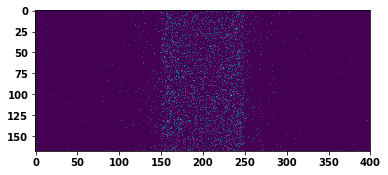

In [332]:
plt.imshow(geometry_normalized_sinogram[tof,mi])
plt.show()

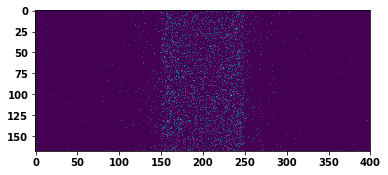

In [333]:
plt.imshow(axial_geometry_normalized_sinogram[tof,mi])
plt.show()

In [ ]:
#crystal interference

In [ ]:
def LOR_bin_efficiency(mi,tx,ro): 
    """ calculate product of sums of detector efficiencies at both detector surface ends of LOR bin at mi,tx,ro"""
    nangles = ncrystals /(2*Utility.AXIAL_COMPRESSION)
    angle = 
    
    midDetectorA = 
    midDetectorB = 
    
    
    return eA*eB

In [290]:
def crystal_pair(ro, angle, mash=1):
    """ return the crystal pair positions within a ring"""
    #print("ro",ro)
    #print("angle         ", angle)
    #ro = robin - Utility.NUMBER_OF_VIEWS //2
    
    ncrystals = Utility.NUMBER_OF_CRYSTALS_PER_RING
    opposite = ncrystals//2
    crystals_per_angle = 2**(1+mash)
    
    nangles = ncrystals /crystals_per_angle
    ro_0_crystal_A = angle*crystals_per_angle//2
    ro_0_crystal_B = ro_0_crystal_A + opposite
    #print("ro_0_crystal_A",ro_0_crystal_A)
    #print("ro_0_crystal_B",ro_0_crystal_B)
    
    #interleaving ro
    crystal_ro_walk = ro//2
    crystal_A = ro_0_crystal_A +  crystal_ro_walk 
    crystal_B = ro_0_crystal_B + (crystal_ro_walk - ro)
    #print("crystal_ro_walk",crystal_ro_walk)
    #print("crystal_A",crystal_A)
    #print("crystal_B",crystal_B)
    
    #verify valid crystal indices
    crystal_A = crystal_A % ncrystals
    crystal_B = crystal_B % ncrystals
    #print("crystal_A after mod",crystal_A)
    #print("crystal_B after mod",crystal_B)
    
    #return the smallest crystal first
    crystal_pair = np.array([crystal_A, crystal_B])
    crystal_pair = np.sort(crystal_pair, axis=0)
    return crystal_pair

In [293]:
def sinogram_bin(d1,d2, mash=1):
    """ take the detector crystals pair d1,d2 and give the sinogram bin tx,ro with angle compression according to mash.
    d1 < d2 assumed """
    ncrystals = normfileKEX.matrices[2].shape[0]
    #print(ncrystals)
    nangles = ncrystals//2
    angle = ((d1+d2+nangles+1) % nangles ) // 2
    radial_element = np.abs(d2-d1-nangles)
    negative_sign=np.any([d1 < angle, d2 > nangles+angle], axis=0)
    radial_element[negative_sign] *= -1
    return angle //(2**mash), radial_element

In [314]:
#test cycle consisitency
# number of angular views
# 
ro,tx = np.meshgrid(np.arange(-200,200,dtype=int), np.arange(0,Utility.NUMBER_OF_VIEWS,dtype=int))
d1, d2 = crystal_pair(ro, tx, mash=0)
tx2,ro2 = sinogram_bin(d1,d2,mash=0)

ro_errors = np.sum(ro != ro2)
tx_errors = np.sum(tx != tx2)
print("ro errors ", ro_errors)

print("tx errors", tx_errors)  
print("of sinogram bins", np.size(ro))

ro errors  0
tx errors 0
of sinogram bins 67200


In [264]:
romax = Utility.NUMBER_OF_PROJECTIONS/2
ro_widget = widgets.IntSlider(min=-romax, max=romax-1, continuous_update=False)
angle_widget = widgets.IntSlider(min=0, max=Utility.NUMBER_OF_VIEWS, continuous_update=False)

def func(ro, angle):
    cp = crystal_pair(ro, angle)

    f = 2*np.pi/Utility.NUMBER_OF_CRYSTALS_PER_RING
    r = 10
    plt.figure(figsize=(r,r))
    
    def ringpoint(ring_number):
        # ring 0 should be at y=1 and x=0
        # then
        x = np.sin(ring_number*f)
        y = -np.cos(ring_number*f)
        return x,y
    
    
    markers = ['g', 'r--', 's','s']
    crystal_numbers = [np.arange(0,Utility.NUMBER_OF_CRYSTALS_PER_RING+1,Utility.NUMBER_OF_CRYSTALS_PER_RING//12),
                       cp,
                      cp[0],
                      cp[1]]
    crystal_numbers[0] -= 2*14
    for k in range(len(markers)):
        x,y = ringpoint(crystal_numbers[k])
        plt.plot(x,y, markers[k])
    
    
    legends = ["ring", "LOR", "A", "B"]
    plt.legend(legends, loc='upper right')
    
    r = 2.2
    plt.xlim(-r,r)
    plt.ylim(-r,r)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.text(0,-1,"crystal 0", horizontalalignment='left')
    
    crystal_next = crystal_numbers[0][3] 
    x,y = ringpoint(crystal_next)
    plt.text(x,y, "crystal " + str(crystal_next), horizontalalignment='left')
    
    plt.text(0,-1.2,"block 0", horizontalalignment='center', bbox=dict(facecolor='red', alpha=0.5))
    plt.gca().invert_yaxis()
    #k=0.5
    #plt.hlines(0,-k,k)
    #plt.vlines(0,-k,k)

interact(func, ro=ro_widget, angle=angle_widget);

interactive(children=(IntSlider(value=0, continuous_update=False, description='ro', max=199, min=-200), IntSli…

In [175]:
print(Utility.FIRST_MI_OF_SEGMENT)
print(Utility.SEGMENT_TABLE)
print(Utility.SEGMENT_OFFSET_MAP)
print((Utility.SEGMENT_OFFSET_MAP) % 9)

[  0 109 206 303 378 453 506 559 590]
[109  97  97  75  75  53  53  31  31]
[ 0  1 -1  2 -2  3 -3  4 -4]
[0 1 8 2 7 3 6 4 5]


In [22]:
ao = Utility.AXIAL_OF_MI[Utility.FIRST_MI_OF_SEGMENT]
k = (2*Utility.NUMBER_OF_RINGS-1)
segi = Utility.SEGMENT_OF_MI[Utility.FIRST_MI_OF_SEGMENT]
p = Utility.AXIAL_COMPRESSION
print(segi)
print(Utility.FIRST_MI_OF_SEGMENT)
print( ao+k*segi - p*(segi))

[0 1 2 3 4 5 6 7 8]
[  0 109 206 303 378 453 506 559 590]
[  0 104 202 311 409 518 616 725 823]


In [ ]:
# compute histo image from sinogram
# matrix multiplication?


def histo_image(sinogram):
    
    # matrix multiplication
    # from 4D to 3D
    # dimension change will require matrix product, not just element-wise
    # is this possible, as some interpolation is required to fit FOV
    #furthermore, the matrix appears to become sparse, as sums are not really expected
    #(mi,rx,to) gets the direction T and origin(z0,0,0)
    #whilst tof gets the t along T
    #
    
    # z = (z0+Tz*t)*mm_to_pixel(z)
    # x = (ro*Rx + Sx*t)*mm_to_pixel(x)
    # y = (ro*Ry + Sy*t)*mm_to_pixel(y)
    
    # (z,y,x) = (tof,mi,tx,ro) * (ro,tx,mi,tof,z,y,x)
    # (mi0,ro,ro) = (tof, mi,tx,ro) 
    
    # GET R and S for sinogram 
    # matrices, one per angle 
    # matrix will take the histogram to semi-circle
    
    # GET C for each sinogram
    # outer product of R with ro
    # add the axial component
    
    # GET RD for each segment
    
    # get T for each sinogram
    
    #get t for each tofbin
    
    #convert from mm to pixel
   

    
    
    
    
    #print("tof", tof)
    #print("unique tof", np.unique(tof))
    #print("unique seg", np.unique(seg))
    #print("unique ro", np.unique(ro))

    #constants
    origin_array = [0, IMAGE_SHAPE[1]//2, IMAGE_SHAPE[2]//2]
    #header file info, relating bins and mm
    #norm /sino / LM file hdr
    mm_per_pixel = np.array([2.027, 4.07283, 4.07283]) 
    mm_per_ro = 2.005
    # header file
    # "transaxial FOV diameter (cm) :=70.4"
    # mCT brochure / Jakoby et al
    # "the industry’s only 78 cm bore ""

    # e7tools vg60 gm_check 1104 (model 1104)
    # ...
    # crystalRadius()=42.76cm
    # ... 
    # sinogramDepthOfInteraction()=0.67cm
    # LORDepthOfInteraction()=0.96cm
    # ...
    #  tofOffset()=0.039ns
    # tofBinSize()=0.3125ns
    # ... 

    #cylinder_radius_mm = 78*10/2
    crystalRadius_mm = 42.76*10
    LORDepthOfInteraction_mm= 9.6
    sinogramDepthOfInteraction_mm=6.7
    cylinderRadius_mm = crystalRadius_mm+LORDepthOfInteraction_mm
    cylinderRadius_mm_square = np.power(cylinderRadius_mm, 2)
    tof_bin_time_s = 312.5*1e-12
    tof_offset_s = tof_bin_time_s / 8.0
    c_lightspeed_m_per_s = 299792458
    
    
    Rx = Utility.Rx
    Ry = Utility.Ry
    Sx = Ry
    Sy = (-1)*Rx
    rmx2 = Utility.AXIAL_OF_MI
    rd = Utility.SEGMENT_OFFSET_MAP[Utility.SEGMENT_OF_MI]
    Tz = rd*Utility.AXIAL_COMPRESSION*
    
    

In [335]:
shapeA = (2,3,4)
shapeB = (2,5,6)
shapeC = (shapeA + tuple(np.flip(shapeB)))
A = np.zeros(shapeA)
B = np.zeros(shapeB)
C = np.zeros(shapeC)
print(np.matmul.__doc__)

matmul(a, b, out=None)

    Matrix product of two arrays.

    The behavior depends on the arguments in the following way.

    - If both arguments are 2-D they are multiplied like conventional
      matrices.
    - If either argument is N-D, N > 2, it is treated as a stack of
      matrices residing in the last two indexes and broadcast accordingly.
    - If the first argument is 1-D, it is promoted to a matrix by
      prepending a 1 to its dimensions. After matrix multiplication
      the prepended 1 is removed.
    - If the second argument is 1-D, it is promoted to a matrix by
      appending a 1 to its dimensions. After matrix multiplication
      the appended 1 is removed.

    Multiplication by a scalar is not allowed, use ``*`` instead. Note that
    multiplying a stack of matrices with a vector will result in a stack of
    vectors, but matmul will not recognize it as such.

    ``matmul`` differs from ``dot`` in two important ways.

    - Multiplication by scalars is not allo

In [ ]:
#In mathematics, matrix multiplication is a binary operation that produces a matrix from two matrices. 
#For matrix multiplication, the number of columns in the first matrix must
#be equal to the number of rows in the second matrix. 
#The result matrix, known as the matrix product, has the number of rows of the first and 
#the number of columns of the second matrix.